In [1]:
import warnings
warnings.filterwarnings("ignore")

# Data Processing
from project_code import processing_functions as pf, visualization_functions as vf
# importlib.reload(vf) 
# importlib.reload(pf) 
from datetime import datetime as dt
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis:  Sunshine Duration and other weather indicators in Bordj Badji Mokhtar, Algeria

Details about the original data set sourced from Open Meteo can be found in the comparison_BBM-TO jupyter notebook.


In [2]:
# read in data 
file_path_data = '../../data/processed_data/'
file_path_figures = 'eda_figures/'
file_name = 'weather_bbm_incl_outliers.csv'
file = f'{file_path_data}{file_name}'
weather_data = pd.read_csv(file)
weather_data.name = 'weather_data'

pf.generate_df_summary(weather_data)

Dataframe: weather_data

------ Head: ------


,date,sunshine_hr,humidity_mean,temp_min,temp_mean,temp_max,temp_range
0,1994-01-01,10.0,29.833333,5.9,13.366667,20.8,14.9
1,1994-01-02,10.0,31.666667,3.2,12.654167,21.1,17.9
2,1994-01-03,10.0,23.958333,5.7,15.166667,24.3,18.6
3,1994-01-04,10.0,20.166667,9.2,17.145833,25.7,16.5
4,1994-01-05,10.0,23.708333,9.0,17.154167,25.6,16.6




------ Tail: ------


,date,sunshine_hr,humidity_mean,temp_min,temp_mean,temp_max,temp_range
10952,2023-12-27,9.976239,14.000000,12.0,20.025000,28.4,16.4
10953,2023-12-28,9.986022,20.666667,11.0,19.029167,27.1,16.1
10954,2023-12-29,9.996114,20.041667,10.6,17.645833,25.3,14.7
10955,2023-12-30,10.000000,14.125000,7.3,16.320833,25.6,18.3
10956,2023-12-31,10.000000,16.041667,9.5,17.866667,27.8,18.3




------ Column Summaries: ------


,count,unique,top,freq
date,10957,10957,1994-01-01,1


,count,mean,std,min,25%,50%,75%,max
sunshine_hr,10957.0,10.820973,1.250392,0.000000,10.110119,10.817328,11.918311,12.084744
humidity_mean,10957.0,18.812570,8.893567,3.291667,12.541667,17.083333,23.083333,85.708333
temp_min,10957.0,20.045587,7.583512,1.400000,13.400000,21.100000,26.900000,34.800000
temp_mean,10957.0,28.040200,7.480956,7.554167,21.275000,29.658333,35.033333,41.045833
temp_max,10957.0,34.975997,7.170943,13.100000,28.800000,36.700000,41.400000,46.900000
temp_range,10957.0,14.930410,2.650838,3.500000,13.200000,15.000000,16.800000,24.300000




------ Counts: ------

Rows: 10,957
Columns: 7
Duplicate Rows = 0 | % of Total Rows = 0.0%


------ Info: ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10957 entries, 0 to 10956
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           10957 non-null  object 
 1   sunshine_hr    10957 non-null  float64
 2   humidity_mean  10957 non-null  float64
 3   temp_min       10957 non-null  float64
 4   temp_mean      10957 non-null  float64
 5   temp_max       10957 non-null  float64
 6   temp_range     10957 non-null  float64
dtypes: float64(6), object(1)
memory usage: 599.3+ KB


None



------ Missing Data Percentage: ------


date             0.0
sunshine_hr      0.0
humidity_mean    0.0
temp_min         0.0
temp_mean        0.0
temp_max         0.0
temp_range       0.0
dtype: float64

There is no missing data, nor are there any duplicate rows. Sunshine duration ranges from 0h to 12h, while the temperature ranges from 1.4C to 46.9C; the latter two figures are derived from the minimum value of the temp_min column and the maximum value of the max_temp column. The widest temperature range on any given day is 24.3C. 

In [3]:
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data.set_index('date', inplace=True)

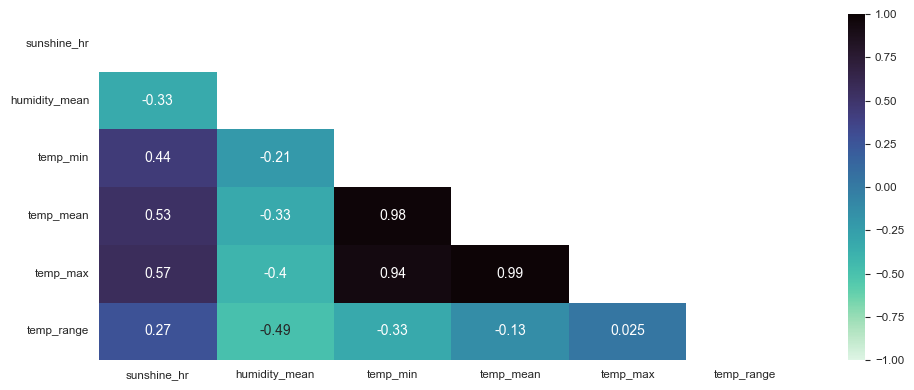

In [4]:

sns.set_style("white")
vf.correlation_matrix(weather_data, figsize=(10,4), cmap='mako_r', name=f'{file_path_figures}correlation_matrix')

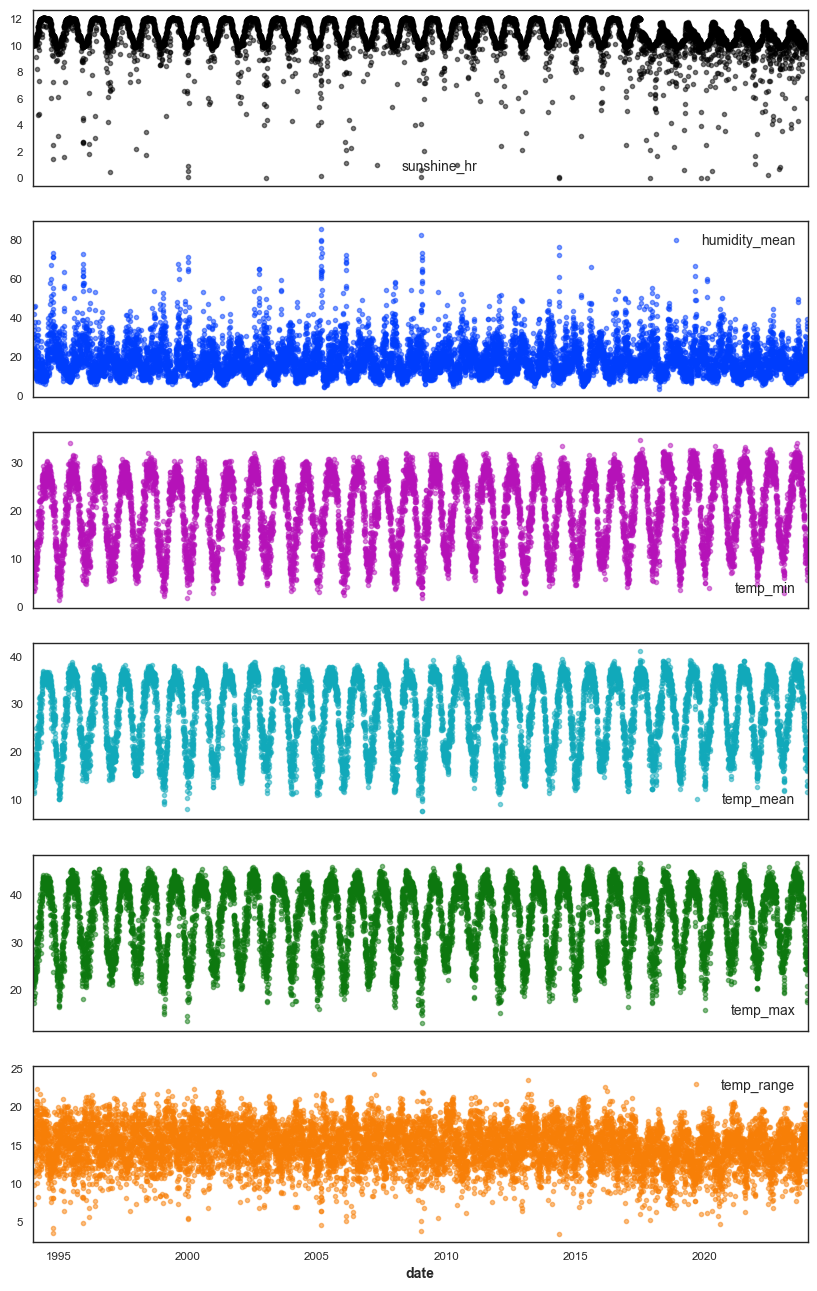

In [ ]:
# sns.set_style("whitegrid", {'grid.linestyle': ':'})

weather_data.plot(marker='.', alpha=0.5,
                                               linestyle='None',
                                                figsize=(10, 16),
                                                subplots=True)
plt.show()

We can see that Sunshine Duration and Temperature exhibit a very clear annual seasonal pattern. While still seasonal, there appears to have been a change to the shape of SD's pattern over the past 6 or so years. 

Let us zero in on Sunshine Duration via decomposition:

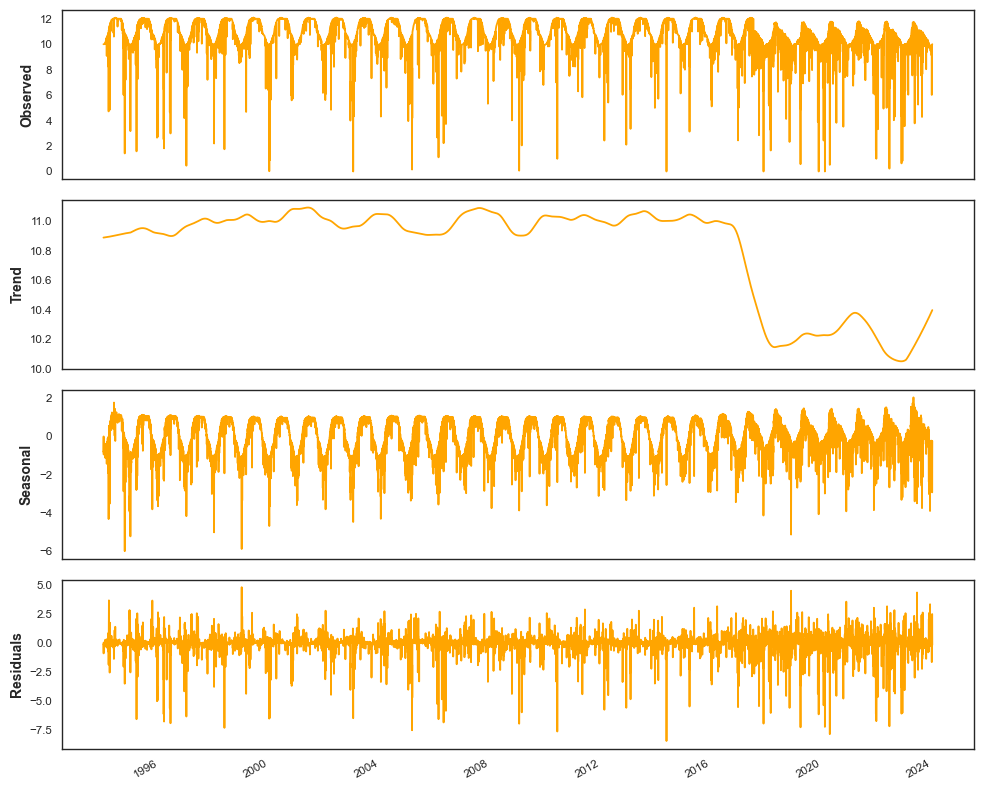

In [6]:
vf.plot_seasonal_decomposition(weather_data, 'sunshine_hr', period=365, color='orange', 
                               name=f'{file_path_figures}seasonal_decomposition')

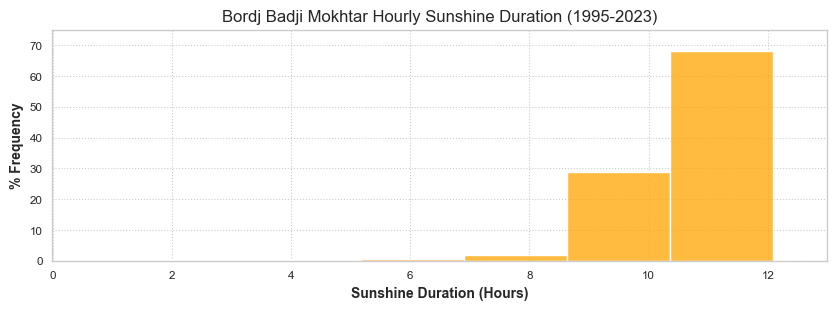

In [7]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
plt.figure(figsize=(10,3))
sns.histplot(weather_data, x='sunshine_hr', bins=7, color='orange',
            stat='percent')
plt.title('Bordj Badji Mokhtar Hourly Sunshine Duration (1995-2023)')
plt.xlabel('Sunshine Duration (Hours)')
plt.ylabel('% Frequency')
plt.xlim(-0.01, 13)
plt.ylim(0,75)
plt.grid(True)
plt.savefig(f'{file_path_figures}hourly_sd_frequency.png')
plt.show()

Almost 70% of the recorded sunshine duration is between ~10.3h and 12h, and less than 3% is below 8.5h. 

For the next part of the analysis, we will create some time-based variables.

In [8]:
# weather_data['date'] = weather_data.index
weather_data['year'] = weather_data.index.year
weather_data['month'] = weather_data.index.month
weather_data['day_of_year'] = weather_data.index.day_of_year


We can now generate some monthly and annual stats:

In [9]:
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']

month_label_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
               'Sep', 'Oct', 'Nov', 'Dec']

annual_monthly_means = weather_data.loc[:, ['sunshine_hr','year', 'month']].groupby(['year','month']).mean().reset_index()
daily_means = weather_data.loc[:, ['sunshine_hr','day_of_year']].groupby('day_of_year').mean().reset_index()

monthly_subset_means = {}

for idx, month in enumerate(month_labels):
    monthly_data = annual_monthly_means[annual_monthly_means['month'] == idx+1]
    monthly_data['3yr_rolling_avg'] = monthly_data.sunshine_hr.rolling(3).mean()
    monthly_subset_means[month] = monthly_data

monthly_subset_means['January'].head()

,year,month,sunshine_hr,3yr_rolling_avg
0,1994,1,10.043660,NaN
12,1995,1,9.999570,NaN
24,1996,1,10.012694,10.018641
36,1997,1,9.332601,9.781622
48,1998,1,9.602243,9.649179


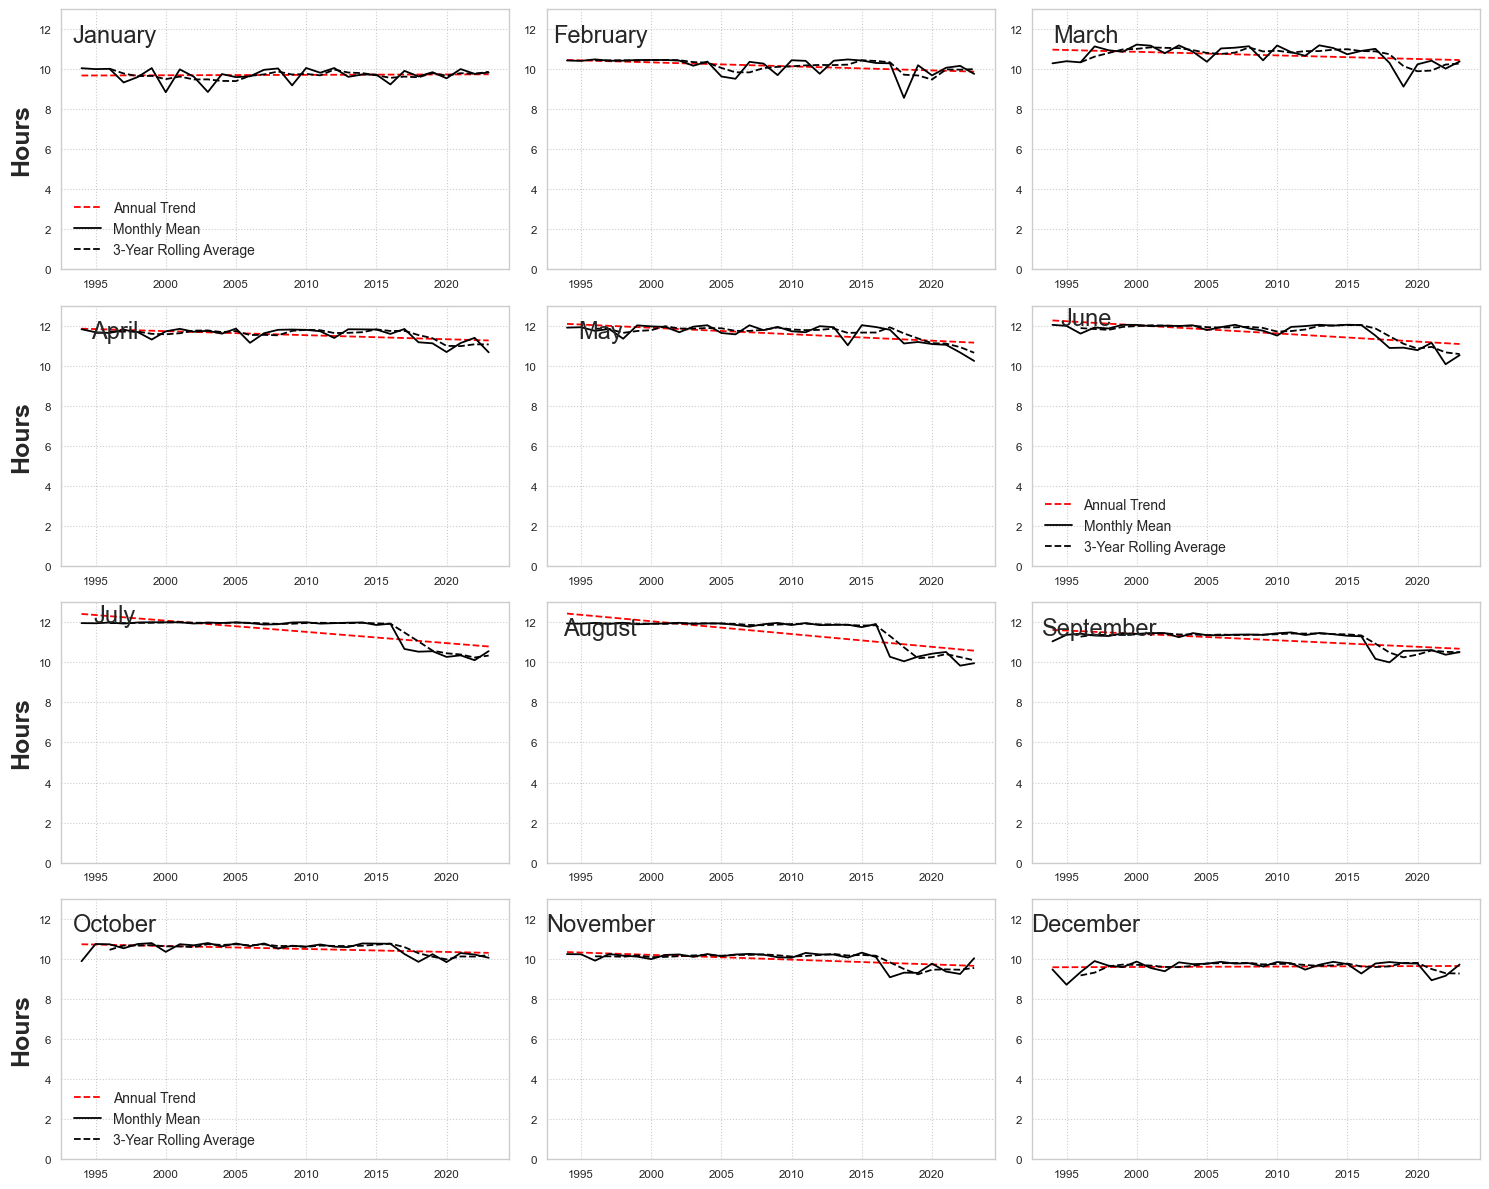

In [10]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
vf.plot_monthly_charts(monthly_data=monthly_subset_means, figsize=(15, 12), column='sunshine_hr', name=f'{file_path_figures}monthly_sunshine_trends')

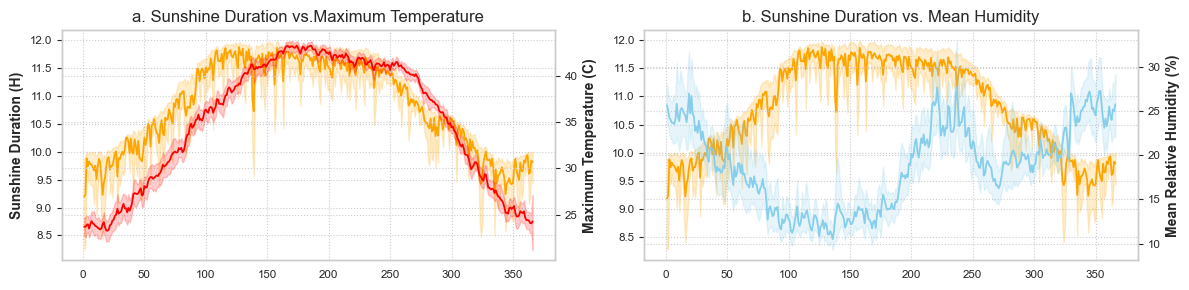

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# fig.suptitle('Monthly Total Sunshine Duration', size=15)

sunshine_hr = 'sunshine_hr'
day_of_year = 'day_of_year'


# Plot Daily Sunshine Duration vs. Max Temperature and Relative Humidity 

sns.lineplot(ax=axes[0], data=weather_data, x=day_of_year, y=sunshine_hr, color='orange')
axes[0].set_ylabel('Sunshine Duration (H)')
axes[0].set_xlabel('')
axes[0].set_title('a. Sunshine Duration vs.Maximum Temperature')
ax2 = axes[0].twinx()
sns.lineplot(ax=ax2, data=weather_data, x=day_of_year, y='temp_max', color='r')
ax2.set_ylabel('Maximum Temperature (C)')


sns.lineplot(ax=axes[1], data=weather_data, x=day_of_year, y=sunshine_hr, color='orange')
axes[1].set_title('b. Sunshine Duration vs. Mean Humidity')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
ax4 = axes[1].twinx()
sns.lineplot(ax=ax4, data=weather_data, x=day_of_year, y='humidity_mean', color='skyblue')
ax4.set_ylabel('Mean Relative Humidity (%)')

fig.tight_layout()
plt.savefig(f'{file_path_figures}daily_trends.png')

We now turn our attention to reviewing the presence of outliers:

In [12]:
weather_data.columns

Index(['sunshine_hr', 'humidity_mean', 'temp_min', 'temp_mean', 'temp_max',
       'temp_range', 'year', 'month', 'day_of_year'],
      dtype='object')

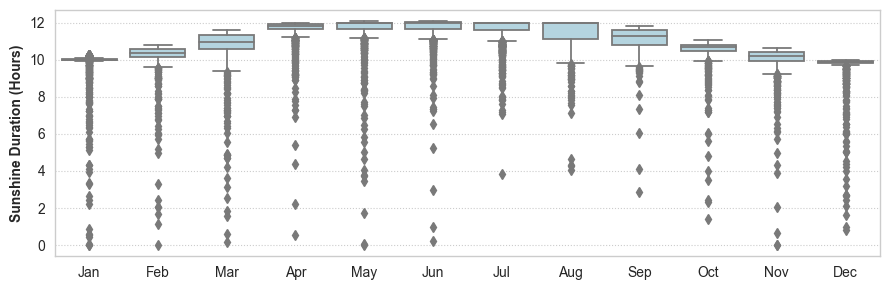

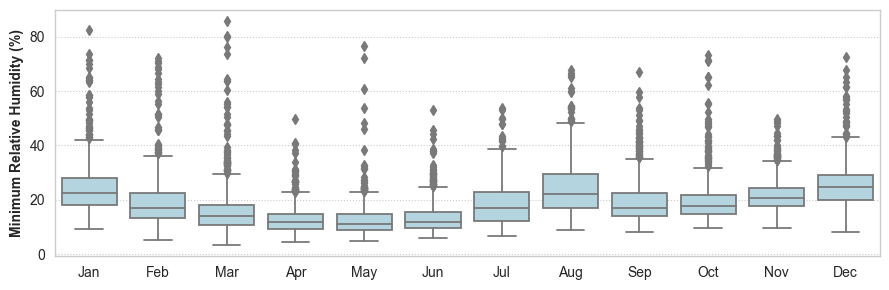

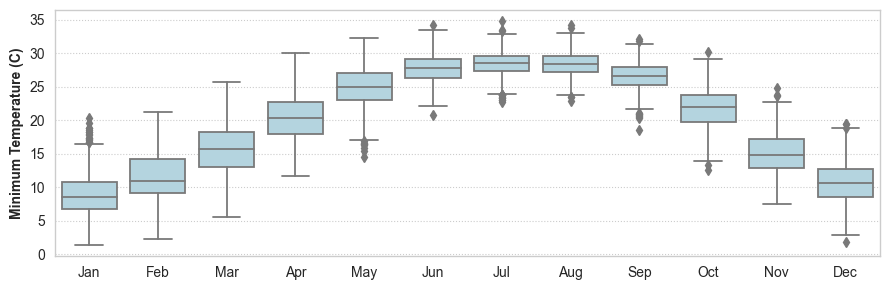

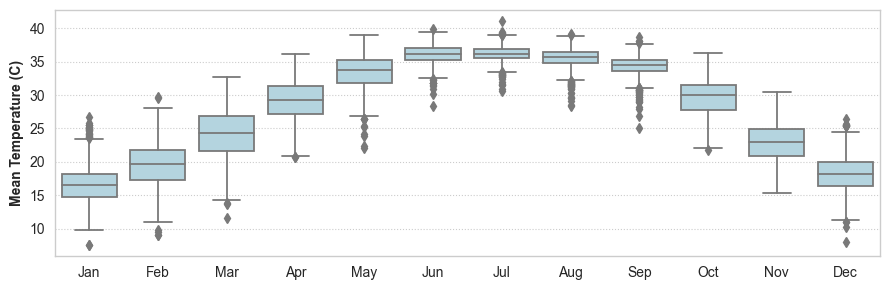

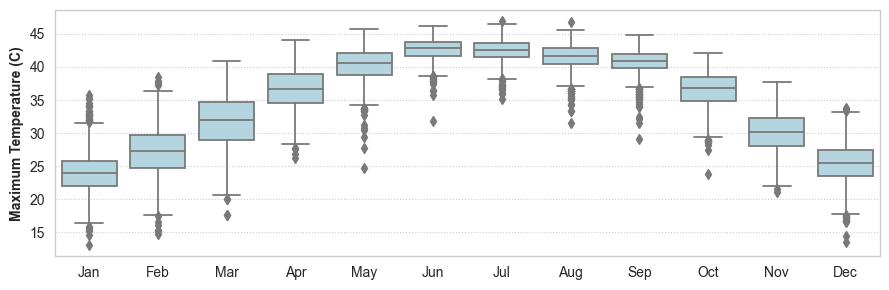

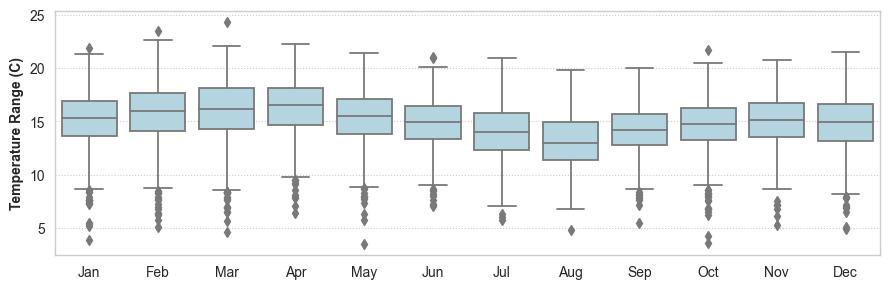

In [13]:
y_labels = {
    'sunshine_hr': 'Sunshine Duration (Hours)',
    'temp_min': 'Minimum Temperature (C)', 
    'temp_mean': 'Mean Temperature (C)',
    'temp_max': 'Maximum Temperature (C)', 
    'temp_range': 'Temperature Range (C)',
    'humidity_mean': 'Minimum Relative Humidity (%)',
}

cols_to_plot = weather_data.columns[:-3]



vf.generate_boxplots(data=weather_data, columns=cols_to_plot, granularity='month',
                     alternate_x_labels=month_label_abbr, y_labels=y_labels,
                    figsize=(9,3), label_font_size=10, tick_font_size=10)


We can see that there are quite a number of outliers in the sunshine duration and relative humidity fields. For the purposes of our experiments, we will be testing model performance on two versions of the data: one with, and one without outliers. We proceed to adjust the outlier values in each column by capping them at +/- 1.5 * IQR (i.e. the limits beyond which a data point is generally considered to be an outlier):

In [14]:
df_clean = pf.adjust_outliers(weather_data, columns=cols_to_plot, granularity='month')

Total outliers adjusted in the sunshine_hr column: 1,299
Percent of total rows: 11.86%


Total outliers adjusted in the humidity_mean column: 419
Percent of total rows: 3.82%


Total outliers adjusted in the temp_min column: 63
Percent of total rows: 0.57%


Total outliers adjusted in the temp_mean column: 158
Percent of total rows: 1.44%


Total outliers adjusted in the temp_max column: 171
Percent of total rows: 1.56%


Total outliers adjusted in the temp_range column: 126
Percent of total rows: 1.15%




We review the results:

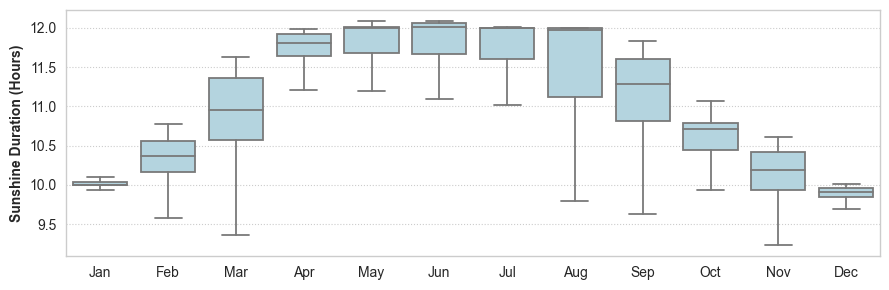

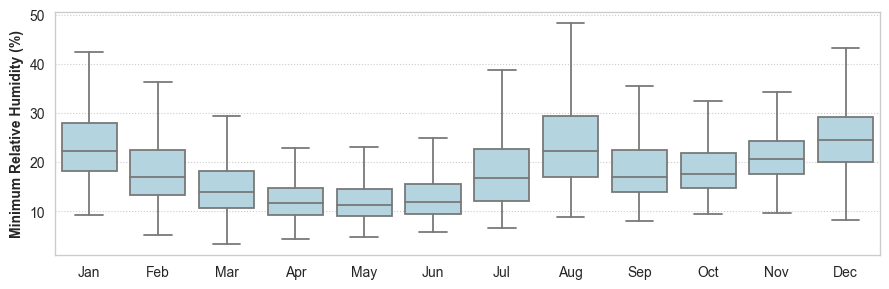

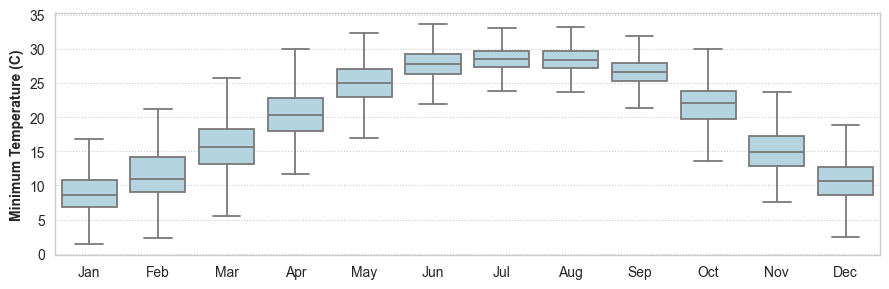

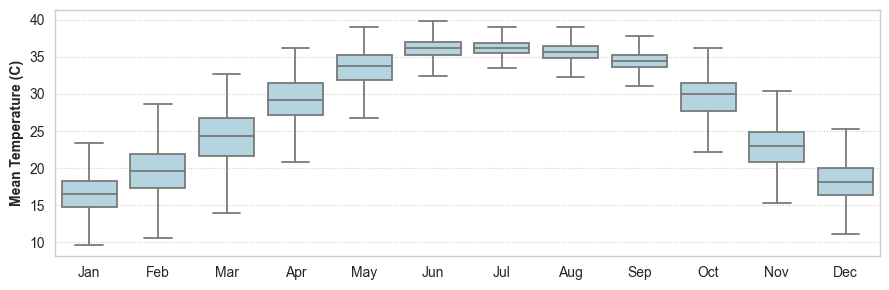

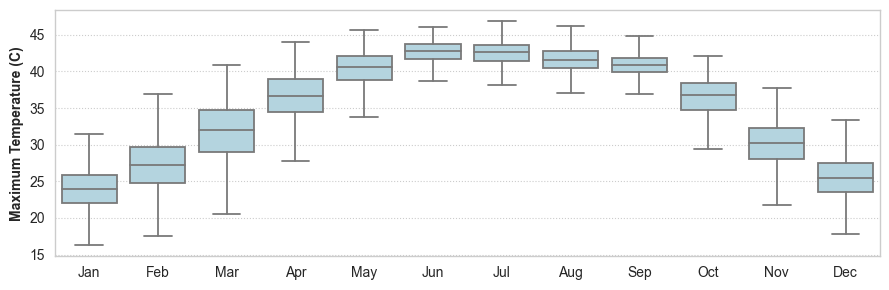

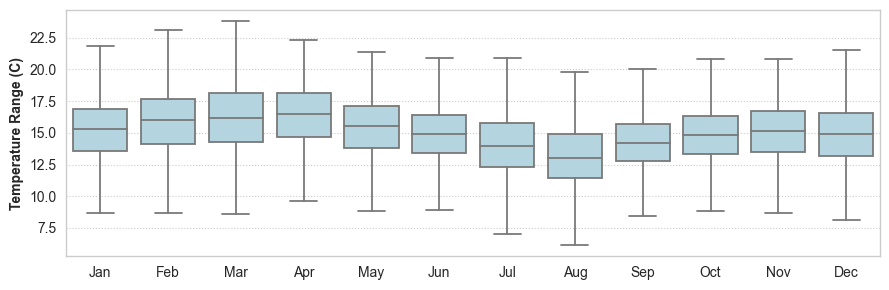

In [15]:
vf.generate_boxplots(data=df_clean, columns=cols_to_plot, granularity='month',
                     alternate_x_labels=month_label_abbr, y_labels=y_labels,
                    figsize=(9,3), label_font_size=10, tick_font_size=10)

Clearing the outliers has shrunken the SD range from 12 hours to less than 3 hours (~9.2h to 12h), which may have some implication for our results. This smaller range could potentially exaggerate model performance, as there may be smaller room for error. 

In [16]:
df_clean.drop(['year', 'month','day_of_year'], axis=1, inplace=True)

display(df_clean.describe())

,sunshine_hr,humidity_mean,temp_min,temp_mean,temp_max,temp_range
count,10957.000000,10957.000000,10957.000000,10957.000000,10957.000000,10957.000000
mean,10.976891,18.440955,20.045059,28.049878,34.991645,14.945601
std,0.830152,7.751610,7.582832,7.481373,7.161424,2.606919
min,9.234177,3.291667,1.400000,9.612500,16.300000,6.150000
25%,10.137133,12.541667,13.400000,21.275000,28.800000,13.200000
50%,10.974664,17.083333,21.100000,29.720833,36.800000,15.000000
75%,11.918311,22.958333,26.900000,35.033333,41.400000,16.800000
max,12.084744,48.302083,33.550000,39.815104,46.862500,23.800000


In [17]:
df_clean.to_csv('weather_bbm_clean.csv')